In [9]:
# Gunnison CHM

In [10]:
import rasterio
path = "s3://planet-snowcover-analysis/VEG/Gunnison__chm_3p0m.tif"
with rasterio.Env(AWS_S3_ENDPOINT='s3.us-west-2.amazonaws.com'):
    with rasterio.open(path) as f:
        img = f.read()

In [11]:
import boto3
session = boto3.Session(profile_name='esip')
# Any clients created from this session will use credentials
# from the [dev] section of ~/.aws/credentials.
dev_s3_client = session.client('s3')


In [12]:
with open('Gunnison__chm_3p0m.tif', 'wb') as f:
    dev_s3_client.download_fileobj('planet-snowcover-analysis', 'VEG/Gunnison__chm_3p0m.tif', f)

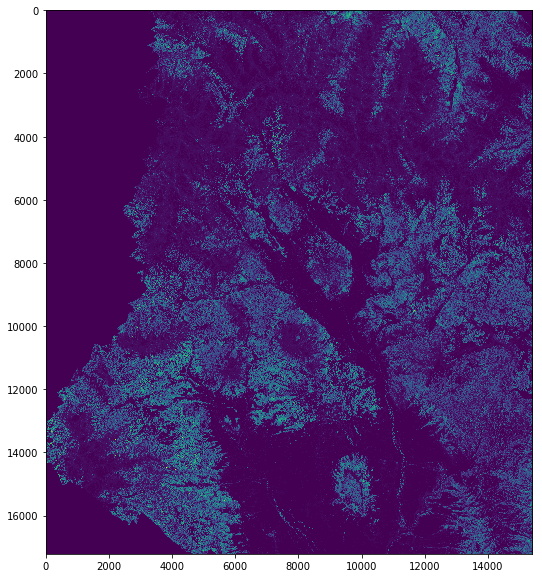

In [13]:
%matplotlib inline
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
import rasterio.plot
import os
from datetime import datetime as dt

# Load the DEM and read out a np array of the elevation values (meters):
dem = rio.open(r'Gunnison__chm_3p0m.tif')
elev = dem.read(1)



# Plot this elevation band:
plt.figure(figsize=(10,10))
plt.imshow(elev)

title_text = ''
plt.title(title_text);


In [18]:
elev

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 11.343262 ,  8.768555 ,
        11.182373 ],
       [ 0.       ,  0.       ,  0.       , ...,  8.9140625, 15.469482 ,
         8.626465 ],
       [ 0.       ,  0.       ,  0.       , ..., 12.951172 , 12.558105 ,
        11.206055 ]], dtype=float32)

In [19]:
# get metadata
dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 15408,
 'height': 17213,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(3.0, 0.0, 305139.0,
        0.0, -3.0, 4330251.0)}

In [20]:
!gdalinfo USCATB20140827_chm_3p0m.tif

Driver: GTiff/GeoTIFF
Files: USCATB20140827_chm_3p0m.tif
Size is 17699, 16780
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32611"]]
Origin = (254247.000000000000000,4229667.000000000000000)
Pixel Size = (3.000000000000000,-3.000000000000000)
Metadata:
  AREA_OR_P

In [21]:
import seaborn as sns

In [22]:
dem.bounds

BoundingBox(left=305139.0, bottom=4278612.0, right=351363.0, top=4330251.0)

In [23]:
#clip the area of interest
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask


In [24]:
dst_crs='EPSG:4326'
transform, width, height = calculate_default_transform(dem.crs, dst_crs, dem.width, dem.height, *dem.bounds)
kwargs = dem.meta.copy()
kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

In [25]:
outpath='veg_Gunnison.tiff'
with rio.open(outpath, 'w', **kwargs) as dst:
            reproject(
                        source=rio.band(dem, 1),
                        destination=rio.band(dst, 1),
                        src_transform=dem.transform,
                        src_crs=dem.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.bilinear)

In [26]:
# Open raster data
import earthpy as et
import earthpy.plot as ep

In [27]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [28]:
# Open data and assign negative values to nan
with rio.open('veg_Gunnison.tiff') as src:
    epsg4326_dem = src.read(1, masked=True)
ds = rio.open('veg_Gunnison.tiff')
print(ds.crs)
print(ds.meta)
# View object dimensions
epsg4326_dem.shape

EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 17723, 'height': 15405, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.077562647586504e-05, 0.0, -107.25338521063615,
       0.0, -3.077562647586504e-05, 39.108744441980996)}


(15405, 17723)

In [29]:
print(epsg4326_dem)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


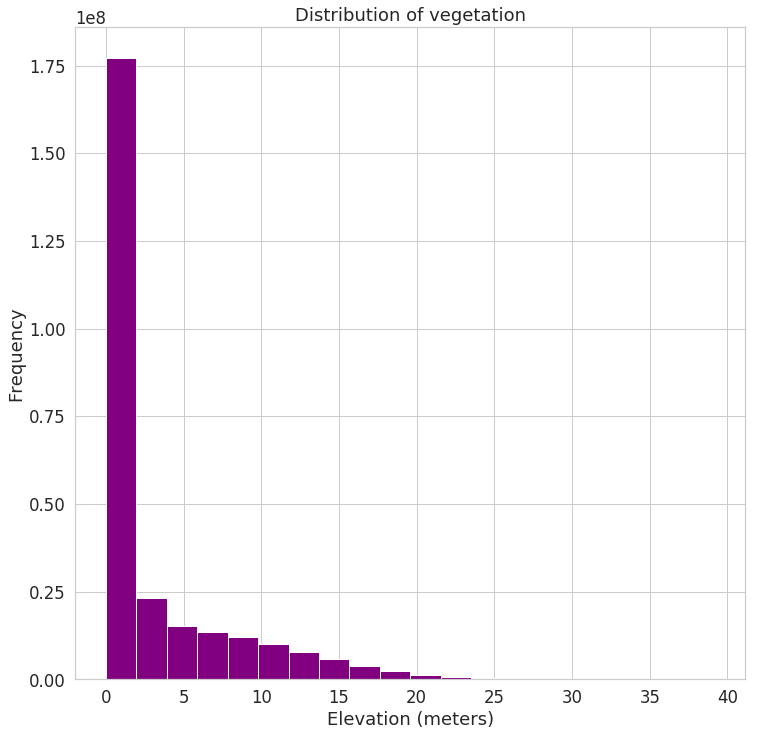

In [30]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
ep.hist(epsg4326_dem, colors=['purple'],
        title="Distribution of vegetation",
        xlabel='Elevation (meters)',
        ylabel='Frequency')
plt.show()

In [20]:
# crop the area
!gdalinfo 12660.tif

Driver: GTiff/GeoTIFF
Files: 12660.tif
Size is 512, 512
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-119.201660156250000,37.822802433527563)
Pixel Size = (0.000021457672119,-0.000016950648287)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (-119.2016602,  37.8228024) (119d12' 5.98"W, 37d49'22.09"N)
Lower Left  (-119.2016602,  37.8141237) (119d12' 5.98"W, 37d48'50.85"N)
Upper Right (-119.1906738,  37.8228024) (119d11'26.43"W, 37d49'22.09"N)
Lower Right (-119.1906738,  37.8141237) (119d11'26.43"W, 37d48'50.85"N)
Center      (-119.1961670,  37.8184631) (119d11'46.20"W, 37d49' 6.47"N)
Band 1 Block=512x1 Type=Float64, ColorInterp=Gray
Band 2 Block=512x1 Type=Float64, ColorInterp=Undefined


In [21]:
!gdalinfo veg.tiff

Driver: GTiff/GeoTIFF
Files: veg.tiff
Size is 19874, 14959
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-119.805754671055084,38.194353568849955)
Pixel Size = (0.000031157584807,-0.000031157584807)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-119.8057547,  38.1943536) (119d48'20.72"W, 38d11'39.67"N)
Lower Left  (-119.8057547,  37.7282673) (119d48'20.72"W, 37d43'41.76"N)
Upper Right (-119.1865288,  38.1943536) (119d11'11.50"W, 38d11'39.67"N)
Lower Right (-119.1865288,  37.7282673) (119d11'11.50"W, 37d43'41.76"N)
Center      (-119.4961418,  37.9613104) (119d29'46.11"W, 37d57'40.72"N)
Band 1 Block=19874x1 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [22]:
import pandas as pd
import pyproj
from geopandas import GeoDataFrame
from shapely.geometry import shape,box
from rasterio.mask import mask
from rasterio.transform import from_origin
# Open data and assign negative values to nan
with rio.open('out.tiff') as origin:
    epsg4326_dem = origin.read(1)
    print('meta origin',origin.meta)
    with rio.open('12660.tif') as src:
        print('planet origin',src.meta)
        #pf = src.read(1, masked=True)
        print(box(*src.bounds))
        clipped_raster,clipped_transform = mask(origin,[box(*src.bounds)],crop=True,nodata= 0)
        print('clipped transform',clipped_transform)
        clipped_meta = origin.meta.copy()
        clipped_meta.update({"driver": "GTiff",
                 "height": clipped_raster.shape[1],
                 "width": clipped_raster.shape[2],
                               "nodata": 0,
                 "transform": clipped_transform})
        print(src.meta,"ds")
        print(clipped_raster[0].shape)
        print(src.crs)
        print(src.meta)
        print(src.shape[1])
        print(src.shape[0])
        print("clipped")
        print(clipped_raster.shape[1])
        print(clipped_raster.shape[2])
    


meta origin {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 19874, 'height': 14959, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(3.115758480714683e-05, 0.0, -119.80575467105508,
       0.0, -3.115758480714683e-05, 38.194353568849955)}
planet origin {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 512, 'height': 512, 'count': 4, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.1457672119140625e-05, 0.0, -119.20166015625,
       0.0, -1.6950648287314407e-05, 37.82280243352756)}
POLYGON ((-119.190673828125 37.81412370160446, -119.190673828125 37.82280243352756, -119.20166015625 37.82280243352756, -119.20166015625 37.81412370160446, -119.190673828125 37.81412370160446))
clipped transform | 0.00, 0.00,-119.20|
| 0.00,-0.00, 37.82|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 512, 'height': 512, 'count': 4, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.145767211914

In [23]:
with rio.open("dem.masked.tif", "w", **clipped_meta) as dest:
    dest.write(clipped_raster) 

In [24]:
dem_m = rio.open('dem.masked.tif')
dem_r = dem_m.read()
print(dem_m.crs)
print(dem_m.meta)

EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 353, 'height': 280, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(3.115758480714683e-05, 0.0, -119.20167141681412,
       0.0, -3.115758480714683e-05, 37.82283052760954)}


In [81]:
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy
scale=1
# Open data and assign negative values to nan
with rio.open('dem.masked.tif') as origin:
        with rio.open('12660.tif') as src:
            t = src.transform
            # # Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
            planet_ndvi = es.normalized_diff(src.read(3), src.read(4))
            # rescale the metadata
            transform = Affine(t.a * scale, t.b, t.c, t.d, t.e * scale, t.f)
            height = int(src.height / scale)
            width = int(src.width / scale)

            profile = origin.profile
            profile.update(transform=transform, driver='GTiff', height=height, width=width)

            #data = raster.read(
            #        out_shape=(origin.count, height, width),
            #        resampling=Resampling.bilinear,
            #    )
            data = origin.read(
                    out_shape=(origin.count, height, width),
                    resampling=Resampling.bilinear,
            )
            with rasterio.open('dem.masked_res.tif', 'w', **profile) as dataset:  # Open as DatasetWriter
                dataset.write(data)
            
            aug_pla_meta = src.profile
            # Change the count or number of bands from 4 to 5
            aug_pla_meta['count'] = 5
            # Change the data type to float rather than integer
            aug_pla_meta['dtype'] = "float64"
            aug_pla_meta
            
            #convert to float64
            ndvi_64 = np.array(planet_ndvi, dtype=numpy.float64)


            # Write band calculations to a new raster file
            with rasterio.open('12660_aug.tif', 'w', **aug_pla_meta) as dstr:
                    dstr.write_band(1, src.read(1))
                    dstr.write_band(2, src.read(2))
                    dstr.write_band(3, src.read(3))
                    dstr.write_band(4, src.read(4))
                    dstr.write_band(5, ndvi_64)
            dstr.close()         

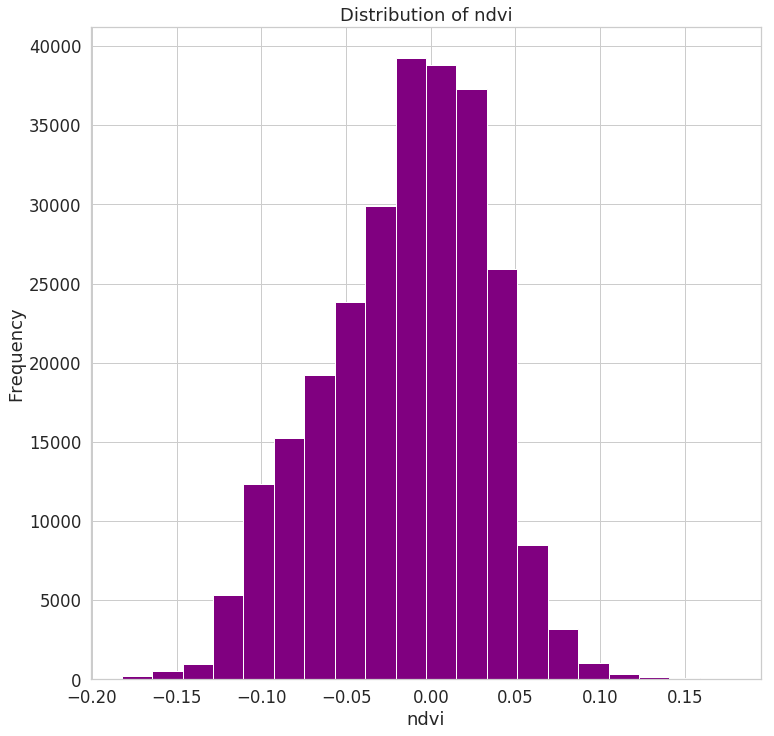

In [59]:
ep.hist(ndvi_64, colors=['purple'],
        title="Distribution of ndvi",
        xlabel='ndvi',
        ylabel='Frequency')
plt.show()

In [72]:
type(blue_64)

numpy.ndarray

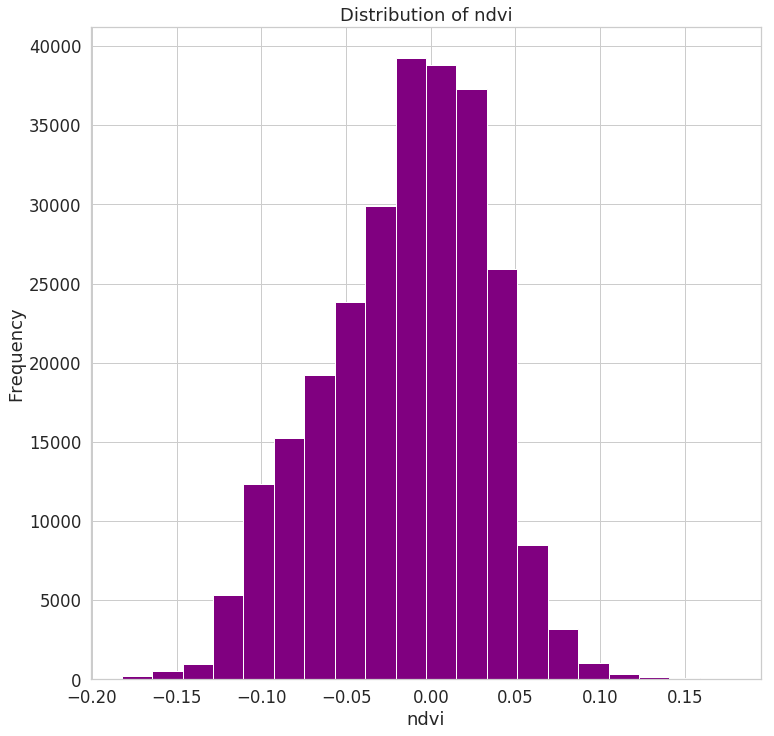

In [82]:
import rasterio
from matplotlib import pyplot
aug_pla = rasterio.open("12660_aug.tif")

ep.hist(aug_pla.read(5), colors=['purple'],
        title="Distribution of ndvi",
        xlabel='ndvi',
        ylabel='Frequency')
plt.show()

In [3]:
dem_res = rio.open('dem.masked_res.tif')
dem_rs = dem_res.read()
print(dem_res.crs)
print(dem_res.meta)
dem_rs

EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.1457672119140625e-05, 0.0, -119.20166015625,
       0.0, -1.6950648287314407e-05, 37.82280243352756)}


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
import rasterio
from matplotlib import pyplot
srced = rasterio.open("dem.masked_res.tif")
pyplot.imshow(srced.read(1), cmap='pink')
pyplot.show()

In [ ]:
import rasterio
from matplotlib import pyplot
srced = rasterio.open("dem.masked.tif")
pyplot.imshow(srced.read(1), cmap='pink')
pyplot.show()

In [ ]:
!gdalinfo dem.masked_res.tif

In [ ]:
ep.plot_bands(dem_r[0], cmap='PiYG', scale=False,
              title="PDEM")
plt.show()

In [ ]:
!gdalinfo 12660.tif

In [ ]:
with rasterio.open('12660.tif', 'r') as dst_new:
        aug_pla_ras = dst_new.read()
        aug_pla_meta = dst_new.profile

In [ ]:
aug_pla_ras[3]

In [ ]:
ep.plot_bands(aug_pla_ras[0], cmap='PiYG', scale=False,
              vmin=-1, vmax=1,
              title="Planet Band 0")
plt.show()

In [ ]:
#Add stuff

# Change the count or number of bands from 4 to 5
aug_pla_meta['count'] = 5
# Change the data type to float rather than integer
aug_pla_meta['dtype'] = "float64"
aug_pla_meta

In [ ]:
dem_rs[0]

In [ ]:
import numpy
#convert to float64
dem_rs_64 = numpy.array(dem_rs[0], dtype=numpy.float64)

In [ ]:
# Write your the dem to raster object
with rio.open('planet_aug.tif', 'w', **aug_pla_meta) as dst_pla:
    dst_pla.write(dem_rs_64, 5)

In [ ]:
with rasterio.open('planet_aug.tif', 'r') as dst_new:
        anew_pla_ras = dst_new.read()
        anew_pla_meta = dst_new.profile

In [3]:
from os import environ
import sys
import io
from os.path import expanduser
sys.path.append("../model/robosat_pink/")
from robosat_pink.config import load_config
config_location= '/home/ubuntu/planet-snowcover/experiments/co-train.toml'
config = load_config(config_location)


In [41]:
import pprint
import s3fs
import boto3
import io
from re import match
%matplotlib inline
import rasterio as rio

p = pprint.PrettyPrinter()

fs = s3fs.S3FileSystem(session = boto3.Session(profile_name = config['dataset']['aws_profile']))

imagery_searchpath = config['dataset']['image_bucket']  + '/' +  config['dataset']['imagery_directory_regex']
print("Searching for imagery...({})".format(imagery_searchpath))
imagery_candidates = fs.ls(config['dataset']['image_bucket'])
print("candidates:")
p.pprint(imagery_candidates)
imagery_locs = [c for c in imagery_candidates if match(imagery_searchpath, c)]
print("result:")
p.pprint(imagery_locs)

    

Searching for imagery...(planet-snowcover-imagery/20180528_.*)
candidates:
['planet-snowcover-imagery/20180423_180737_1009_3B_AnalyticMS_DN_udm_clip.tif',
 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_DN_udm_clip.tif',
 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_SR_clip.tif',
 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_metadata_clip.xml',
 'planet-snowcover-imagery/20180601_181447_0f32_metadata.json',
 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_DN_udm_clip.tif',
 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip.tif',
 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_metadata_clip.xml',
 'planet-snowcover-imagery/20180601_181448_0f32_metadata.json',
 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_DN_udm_clip.tif',
 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_SR_clip_scaled.tif',
 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_metadata_clip.xm

In [ ]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np
import numpy
%matplotlib inline
import rasterio as rio
from matplotlib import pyplot as plt
import rasterio.plot
import os
from datetime import datetime as dt
from rasterio.io import MemoryFile
import tempfile
#create the files with 5 babds
for link in imagery_locs:
    #print(link)
    #sub_candidates = fs.ls(link)
    #print(sub_candidates)
    #dev_s3_client.list_objects(link) 
    s3 = boto3.resource('s3')
    s3_client = boto3.client('s3')

    bucket=link.partition('/')[0] 
    my_bucket = s3.Bucket(bucket)
    for my_bucket_object in my_bucket.objects.filter(Prefix=link.partition('/')[2]):
        #print(my_bucket_object)
        print('{0}:{1}'.format(my_bucket.name, my_bucket_object.key))
        with rio.open('s3://{0}/{1}'.format(my_bucket.name, my_bucket_object.key)) as src:
            #print(src.meta)
            # # Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
            planet_ndvi = es.normalized_diff(src.read(3), src.read(4))
            aug_pla_meta = src.profile
            # Change the count or number of bands from 4 to 5
            aug_pla_meta['count'] = 5
            # Change the data type to float rather than integer
            aug_pla_meta['dtype'] = "float64"
            aug_pla_meta
            
            #convert to float64
            ndvi_64 = np.array(planet_ndvi, dtype=numpy.float64)

            new_bucket = s3.Bucket('planet-snowcover-imagery-augmented')
            temp_file = tempfile.TemporaryFile()
            #with tempfile.NamedTemporaryFile() as tmpfile:
            #tmpfile.write(data)
            #with rasterio.open(tmpfile.name) as dataset:
            #data_array = dataset.read()
            
            with tempfile.NamedTemporaryFile() as tmpfile:
                with rasterio.open(tmpfile.name,
                               'w', **aug_pla_meta) as dstr:
                    dstr.write_band(1, src.read(1))
                    dstr.write_band(2, src.read(2))
                    dstr.write_band(3, src.read(3))
                    dstr.write_band(4, src.read(4))
                    dstr.write_band(5, ndvi_64)
                dstr.close()   
            
                s3_client.upload_fileobj(tmpfile, new_bucket.name, my_bucket_object.key)  
                # Write band calculations to a new raster file
               
        
        

planet-snowcover-imagery:20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12660.tif
planet-snowcover-imagery:20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12661.tif
planet-snowcover-imagery:20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12662.tif
planet-snowcover-imagery:20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12663.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5532/12669.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5532/12670.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12665.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12666.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12667.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12668.tif
planet-snowcover-imagery:20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12669.tif
planet-snowcover-imagery:20180528_180847_1002_3B_Analy

In [ ]:
            with rasterio.open('s3://{0}/{1}'.format(new_bucket.name, my_bucket_object.key),
                               'w', **aug_pla_meta) as dstr:
                    dstr.write_band(1, src.read(1))
                    dstr.write_band(2, src.read(2))
                    dstr.write_band(3, src.read(3))
                    dstr.write_band(4, src.read(4))
                    dstr.write_band(5, ndvi_64)
            dstr.close()        

In [ ]:
            with MemoryFile() as memfile:
                with memfile.open(**aug_pla_meta) as dataset:
                    dataset.write(src.read(1), 1)
                    dataset.write(src.read(2),2)
                    dataset.write(src.read(3),3)
                    dataset.write(src.read(4),4)
                    dataset.write(ndvi_64,5)

In [62]:
!aws s3 ls s3://planet-snowcover-imagery-augmented --recursive --summarize

2020-02-06 02:58:24   10490262 20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12660.tif
2020-02-06 02:58:25   10490262 20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12661.tif
2020-02-06 02:58:25   10490262 20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12662.tif
2020-02-06 02:58:26   10490262 20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12663.tif
2020-02-06 02:58:26   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5532/12669.tif
2020-02-06 02:58:27   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5532/12670.tif
2020-02-06 02:58:28   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12665.tif
2020-02-06 02:58:28   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12666.tif
2020-02-06 02:58:29   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12667.tif
2020-02-06 02:58:29   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/5533/12668.tif
2020-02-06 02:58:30   10490262 20180528_180847_1002_3B_AnalyticMS_SR_clip/15/553

'planet-snowcover-imagery'